# Tutorial \#2: Integrating Geo2SigMap with Sionna RT - Point-to-Point Ray Tracing with Detailed Analysis

This notebook provides an example of using Sionna RT to generate the point-to-point rays for the target area generated using our scene generation framework. This example contains seven modules:

1. **Load and Preview** the generated scene for the target area;
2. **Generate** random receiver (RX) locations in outdoor environments;
3. **Configure** the transmitters (TXs) and receivers (RXs);
4. **Compute** path (rays) for each TX-RX pair;
5. **Visualize** the paths (rays) using Sionna's built-in functions;
6. **Save** the raw information for individual rays;
7. **Analyze** the generated rays.


Please make sure that you have properly installed Sionna:
```console
python3 -m pip install sionna
```

In [1]:
# Core imports
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, PathSolver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr

## 1. **Load and Preview** the existing scene

We assume you have prepared the 3D scene XML file corresponding to the target area generated with our CLI tool `scenegen`, check the `README.md` of this repo for details. 

You can use the following controls:
* Mouse left: Rotate
* Scroll wheel: Zoom
* Mouse right: Move

In [2]:
# Load scene and access Mitsuba's internal representation
scene = load_scene("../scenes/Boston/scene.xml")

# Interative 3D visualization and view of the scene
scene.preview();

2025-06-10 06:07:23 WARN wrk16 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

## 2. **Generate** random RX locations in the outdoor environment

- Generate candidate RX locations within the target scene. Note that RXs cannot be located inside a building;
- Filter out potential indoor RX locations using upward ray tracing.

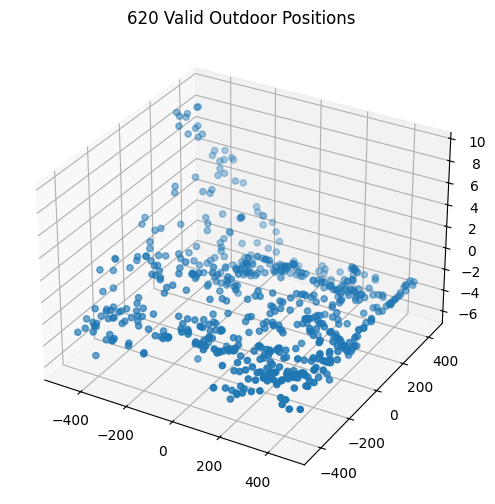

In [3]:
# Obtain the Mitsuba scene object from Sionna scene object 
mi_scene = scene.mi_scene

# Generate candidate positions (1.5m height = typical UE height)
num_candidates = 1000

import trimesh

# Load the terrain mesh
mesh = trimesh.load('../scenes/Boston/mesh/lidar_terrain.ply')

# Sample N points uniformly on the surface
points, face_indices = trimesh.sample.sample_surface(mesh, num_candidates)

candidates = np.asarray(points)
candidates[:, 2] += 1.5
# Create a direction vector pointing upwards (towards the sky) 
# and tile it to match the number of positions
directions_np = np.tile(np.array([0, 0, 1]), (num_candidates, 1))

# Ray tracing validation
rays = mi.Ray3f(
    # mi.Vector3f(candidates),
    mi.Vector3f(np.array(candidates, dtype=np.float32).T),
    mi.Vector3f(np.array(directions_np, dtype=np.float32).T)
)
si = mi_scene.ray_intersect(rays)
valid_mask = ~si.is_valid()

# Filter and visualize
valid_positions = candidates[valid_mask]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_positions[:,0], valid_positions[:,1], valid_positions[:,2])
ax.set_title(f"{len(valid_positions)} Valid Outdoor Positions")
plt.show()

## 3. **Configure** the transmitters (TXs) and receivers (RXs)

Next, we specify:
- The **transmit (TX)** antenna array is a planar array with a single element and isotropic pattern;
- The **receive (RX)** antenna array is a planar array with a single element but with a dipole pattern.

Then, we create a `Transmitter` object with a specific position and orientation, and add it to the `scene`. Then, 10 valid RX locations from the above step are randomly selected.

**Note: Scene geographical coordinate system**
- Coordinate system: The center of the scene is at (0,0,0), the z-axis for the flat ground polygon is 0.
- Units: Meters (m).

**Note: Sionna Azimuth/Elevation Format**
- Sionna defines the **antenna azimuth** in the range [-π, π) [rad]. The following code converts the commonly used **north-origin, clockwise-degree azimuth** to the formate suitable for Sionna. Check the code below for details.

In [4]:
# Array configurations

# Transmitter array (single isotropic element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="V"
)

# Random select 10 receivers form valid_positions (Outdoor positions)
for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=10, replace=False)]):
    rx = Receiver(
        name=f"rx{i}",
        position=pos,
        orientation=[0, 0, 0] 
    )
    scene.add(rx)

# Transmitter configuration
tx = Transmitter(
    name="tx",
    position=[0, 0, 100],  # Elevated position
    orientation=[-1 * (210 - 90) / 180 * np.pi, 0, 0]  # 210° azimuth tilt
)
scene.add(tx)

# Validate setup
scene.preview();

## 4. **Compute** path (rays) for each TX-RX pair

- `max_depth=3` (maximum number of reflections/refractions/diffractions);
- `diffraction=True` to include diffraction effects;
- `scattering=True` to include scattering effects;
- `scat_keep_prob` specifies the probability with which a scattered path is kept;
- `num_samples=int(1e6)` specifies how many rays are sampled (reduce if running out of memory).

**Note**:
Reduce the number of samples if you observe out-of-memory error.

In [5]:
# Configure simulation parameters
scene.frequency = 3.66e9  # 3.66 GHz carrier
scene.synthetic_array = True  # Optimize for array calculations

# Perform ray tracing

solver = PathSolver()
paths = solver(scene, max_depth=3,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    refraction=False,
    samples_per_src=1000000
)


## 5. **Visualize** the paths (rays) using Sionna built-in functions

In [6]:
# Preview the scene with paths
scene.preview(paths=paths);

## 6. **Save** the raw information for individual rays
- `a`: Complex-valued path gain;
- `tau`: Path delay;
- `phi/theta`: Azimuth/elevation angles;
- `type`: LoS/Reflected/Diffracted/Scattered.

In [7]:
# Convert paths to analyzable format

print(dir(paths))

def paths_to_dict(paths):
    members_names = dir(paths)
    members_objects = [getattr(paths, attr) for attr in members_names]
    data = {
        attr_name[1:]: attr_obj
        for attr_obj, attr_name in zip(members_objects, members_names)
        if not callable(attr_obj)
        # Uncomment and adjust the next line if scene_module.Scene is still relevant:
        # and not isinstance(attr_obj, scene_module.Scene)
        and not attr_name.startswith("__")
        and attr_name.startswith("_")
    }
    return data

ray_data = paths_to_dict(paths)
print(ray_data)
# Create structured dataset
def create_ray_dataset(ray_dict, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        'rx_coord':[]
    }
    
    type_map = {0: "LoS", 1: "Reflected", 2: "Diffracted", 3: "Scattered"}
    
    #a = ray_dict["a"].numpy().squeeze()
    tau = ray_dict["tau"].numpy().squeeze()
    types = ray_dict["interactions"].numpy().squeeze()
    mask = ray_dict["valid"].numpy().squeeze()
    phi_r = ray_dict["phi_r"].numpy().squeeze()
    phi_t = ray_dict["phi_t"].numpy().squeeze()
    theta_r = ray_dict["theta_r"].numpy().squeeze()
    theta_t = ray_dict["theta_t"].numpy().squeeze()
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        
        # Filter out the RX which have no rays related
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    dataset["type"].append(type_map[types[sub_idx]])
                    dataset["a"].append(a[idx,sub_idx])
                    dataset["tau"].append(tau[idx,sub_idx])
                    dataset["freq"].append(frequency)
                    
                    # Store the list instead of np.array to avoid the space sepreator in csv
                    dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
                    dataset["rx_id"].append(idx)

    return pd.DataFrame(dataset)

# Generate analysis dataframe
df = create_ray_dataset(ray_data, frequency=3.66e9)
df.head()

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_a_imag', '_a_real', '_apply_synthetic_array', '_build_empty_paths', '_build_from_buffer', '_build_paths_components', '_doppler', '_eff_rx_array_size', '_eff_tx_array_size', '_finalize_doppler_shift_compute', '_frequency', '_fuse_pattern_array_dims', '_interactions', '_max_num_paths', '_num_rx', '_num_tx', '_path_ind', '_paths_buffer', '_paths_components_built', '_phi_r', '_phi_t', '_primitives', '_reverse_direction', '_rx_ant_ind', '_rx_array', '_rx_ind', '_rx_velocities', '_shapes', '_src_positions', '_synthetic_array', '_tau', '_tgt_positions', '_theta_r', '_theta_t', '_tx_ant_ind', '_tx_array', '_tx_ind', '_tx_velocities', '_v

TypeError: unhashable type: 'numpy.ndarray'

## 7. **Analyze** the generated rays

The examples below provide the following analysis:
- A histogram with respect to different ray types;
- CDF of the path gain across all rays.

In [ ]:
import matplotlib.pyplot as plt

# Get distinct values of ray types
distinct_types = df['type'].unique()

# Get distinct values of freq
distinct_freqs = df['freq'].unique()

values = []
for freq in distinct_freqs:
    tmp_value = []
    for ray_type in distinct_types:
        tmp_value.append(len( df.query("freq == {} and type == '{}'".format(freq, ray_type)) ))
    values.append(tmp_value)
values = np.array(values)

# Create an array for the positions of each group
group_positions = np.arange(len(distinct_types))

# Width of each bar
bar_width = 0.1

# Creating the horizontal bar chart
fig, ax = plt.subplots()

for i in range(len(distinct_freqs)):
    # Position of the bars on the x-axis
    positions = group_positions + i * bar_width
    print(positions)
    ax.barh(positions, values[i,:], height=bar_width, label="{} Ghz".format(distinct_freqs[i]/1e9))

# Adding labels
ax.set_yticks(group_positions + bar_width)
ax.set_yticklabels(distinct_types)
ax.set_xlabel('Values')
ax.set_title('Distribution of Rays Across Categories and Freqency')

# Adding value labels on top of the bars
for i in range(len(distinct_freqs)):
    for j in range(len(distinct_freqs)):
        ax.text(values[i, j], j + i * bar_width, str(values[i, j]), va='center')

# Adding legend
ax.legend()

# Adding legend with reversed order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Display the chart
plt.show()

In [ ]:
def multi_cdf(data_df, target_column, title,  x_label = 'Value', y_label = 'CDF', normalized=False):
    # Get distinct values of ray types
    distinct_types = df['type'].unique()
    
    # Get distinct values of freq
    distinct_freqs = df['freq'].unique()

    colors = ["blue","green", "red"]

    # Function to compute CDF
    def compute_cdf(data):
        if len(data) == 1:
            # Special case for single data point
            data_sorted = np.array([data[0], data[0]])
            cdf = np.array([0, 1])
        else:
            data_sorted = np.sort(data)
            cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        return data_sorted, cdf
    
    # Plotting the CDFs
    plt.figure(figsize=(10, 6))
    for i, freq in enumerate(distinct_freqs):
        tmp_df = data_df.query("freq == {} and type!= 3".format(freq))
        
        if normalized:
            tmp_df.loc[:,target_column] = tmp_df[target_column] - tmp_df[target_column].max()

        # Compute CDFs for each class
        tmp_x, tmp_cdf = compute_cdf( tmp_df[target_column].to_list())
        plt.plot(tmp_x, tmp_cdf, label="{} Ghz".format(freq/1e9), color=colors[i])
    
    # Adding titles and labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Path Gain
tmp_df = df[['freq', 'a', 'type']].copy()
tmp_df.loc[:,'pathGain'] = 20*np.log10(np.abs(tmp_df['a']))
multi_cdf(tmp_df, "pathGain", "CDF for Path Gain (Normalized)", "Normalized Path Gain (dB)", normalized = True)

**Closing Remark**:
Please refer to the [Sionna Documentation](https://nvlabs.github.io/sionna/) for more advanced features!